In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from decorrelation.plotting import *
from decorrelation.utils import generate_correlated_data

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
def rule_1_full(d=100, num_samples=1000, num_iters=300, lr=1e-1, kappa=0.5, seed=42):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    data = generate_correlated_data(d, num_samples)

    neg_eye = 1.0 - torch.eye(d)

    R = torch.eye(d)
    loss = torch.zeros(num_iters)
    for i in range(num_iters):

        X = data @ R

        # covariance without diagonal
        C = neg_eye * (X.T @ X / len(X))
            
        # unit variance term averaged over datapoints
        v = torch.mean(X**2 - 1.0, axis=0)

        # compute update; equation (4) in technical note
        # R = R - (lr/d) * ((1.0 - kappa)/(d-1) * C @ R + 2 * kappa * v * R)
        R = R - lr * (((1.0 - kappa)/(d-1)) * C @ R + 2 * kappa * v * R)

        # compute loss
        loss[i] = (1/d) * (((1-kappa)/(d-1)) * torch.sum(C**2) + kappa * torch.sum(v**2))
        # loss[i] = (1-kappa)/(d-1) * torch.sum(C**2) + kappa * torch.sum(v**2)

    return R, loss, data


In [34]:
# data = generate_correlated_data(100, 1000) 
# torch.mean(data, axis=0), torch.var(data, axis=0)


In [59]:
# check variance constraint
R, loss, data = rule_1_full(d=50, kappa=1.0, lr=1e-1)
torch.mean(data @ R, axis=0), torch.var(data @ R, axis=0)

(tensor([-3.8147e-09, -1.1444e-08, -8.1062e-09,  1.3351e-08,  1.9073e-09,
          1.3351e-08,  5.7220e-09, -1.3351e-08,  1.3947e-08,  7.6294e-09,
          1.9073e-09,  1.3351e-08, -1.7792e-08,  5.7220e-09,  1.9073e-09,
         -7.1526e-09,  1.3351e-08,  1.4305e-09,  2.3842e-08,  5.7220e-09,
         -1.4305e-08,  5.7220e-09,  2.1458e-09, -1.3351e-08,  2.6703e-08,
          1.9073e-08,  1.2398e-08,  3.8147e-09, -2.8610e-09, -9.5367e-09,
         -2.8610e-09,  9.0599e-09, -1.3828e-08,  1.3471e-08, -1.3113e-08,
         -5.7220e-09, -6.6757e-09, -3.8147e-09,  0.0000e+00, -9.5367e-09,
         -7.6294e-09, -9.5367e-10, -1.3351e-08, -1.3351e-08, -1.5259e-08,
          7.1526e-09,  5.7220e-09, -1.3351e-08,  5.7220e-09,  1.8120e-08]),
 tensor([1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010,
         1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010,
         1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010, 1.0010,
         1.0010

In [40]:
R1, loss1, data1 = rule_1_full(d=50, kappa=0.5, lr=1e0)
R2, loss2, data2 = rule_1_full(d=500, kappa=0.5, lr=1e0)

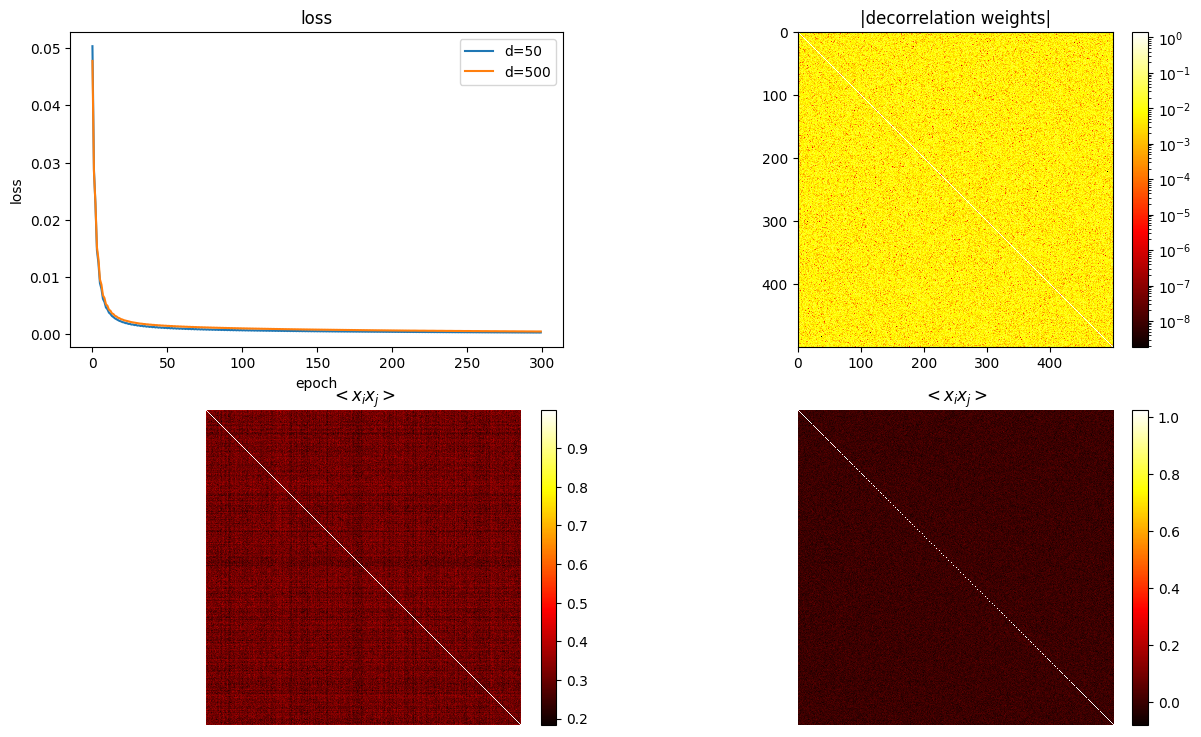

In [41]:
fig, ax = plt.subplots(2,2, figsize=(14, 9))
plot_loss(ax[0,0], loss1, loss2)
ax[0,0].legend(['d=50', 'd=500'])
plot_decorrelation_matrix(ax[0,1], R2)
C1 = data2.T @ data2 / len(data2)
plot_covariance_matrix(ax[1,0], C1)
X = data2 @ R2
C2 = X.T @ X / len(X)
plot_covariance_matrix(ax[1,1], C2)

In [5]:
# sanity checking for rule 1

seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# covariances

C = torch.rand(9,9)
R = torch.rand(9,9)
# R = (R + R.T) / 2

U = torch.zeros(9,9)
for i in range(9):
    for j in range(9):
        U[i] += C[i,j] * R[j]
print(U)

V = C @ R
print(V)

# variances

C = torch.diag(torch.rand(9))
R = torch.rand(9,9)
# R = (R + R.T) / 2

U = torch.zeros(9,9)
for i in range(9):
    for j in range(9):
        U[i] += C[i,j] * R[j]
print(U)

V = C @ R
print(V)



tensor([[1.5075, 2.8469, 3.5497, 4.2543, 3.3179, 2.5944, 2.0448, 2.7879, 2.7719],
        [1.4998, 2.0945, 3.5697, 3.7646, 3.0985, 2.1759, 2.0260, 2.5678, 2.2127],
        [0.9348, 1.2623, 2.2664, 2.1893, 1.9215, 1.5310, 1.1213, 1.7028, 1.4083],
        [1.1398, 1.6719, 2.6461, 2.8817, 2.7194, 1.9115, 1.2400, 2.6864, 1.9163],
        [1.5376, 2.5649, 2.8692, 4.0493, 2.8977, 2.6087, 2.0443, 2.6483, 2.2526],
        [0.8497, 1.7943, 2.0894, 2.6933, 1.7019, 1.6544, 1.3509, 1.8313, 1.6968],
        [0.9850, 2.0211, 2.1794, 3.1810, 1.9702, 2.3530, 1.3897, 2.0024, 1.8587],
        [1.1288, 2.0522, 2.8165, 3.2099, 2.5557, 1.5505, 1.6958, 1.9181, 2.0143],
        [1.0752, 1.7667, 1.8801, 2.7411, 2.4662, 2.0608, 0.9819, 2.0118, 1.6662]])
tensor([[1.5075, 2.8469, 3.5497, 4.2543, 3.3179, 2.5944, 2.0448, 2.7879, 2.7719],
        [1.4998, 2.0945, 3.5697, 3.7646, 3.0985, 2.1759, 2.0260, 2.5678, 2.2127],
        [0.9348, 1.2623, 2.2664, 2.1893, 1.9215, 1.5310, 1.1213, 1.7028, 1.4083],
        [1.1398

In [115]:
def rule_2_full(d=100, num_samples=1000, num_iters=300, lr=1e0, kappa=0.5, seed=42):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    # generate correlated data
    data = generate_correlated_data(d, num_samples, strength=0.5)
    
    neg_eye = 1.0 - torch.eye(d)

    R = 1e-1*torch.randn(d, d) * neg_eye + torch.eye(d) # HERE; CHECK VARIANCE NORMALISATION!!! => DIAGONAL SEEMS NOT TO BE LEARNT PROPERLY 
    loss = torch.zeros(num_iters)
    for i in range(num_iters):

        X = data @ R

        c = torch.mean(X**2, axis=0)[:, None]

        # or diag(neg_eye @ c) @ R 
        U = neg_eye @ c
   
        # unit variance term averaged over datapoints
        v = torch.mean(X**2 - 1.0, axis=0)

        # compute update; equation (4) in technical note
        R = R - lr * (((1.0 - kappa)/(d-1)) * U  * R + 2 * kappa * v * R)

        # compute loss
        C = neg_eye * (X.T @ X / len(X)) # only for loss computation
        loss[i] = (1/d) * (((1-kappa)/(d-1)) * torch.sum(C**2) + kappa * torch.sum(v**2))

    return R, loss, data


In [116]:
# check variance constraint
# R, loss, data = rule_2_full(d=50, kappa=1.0, lr=1e-1)
# torch.mean(data @ R, axis=0), torch.var(data @ R, axis=0)

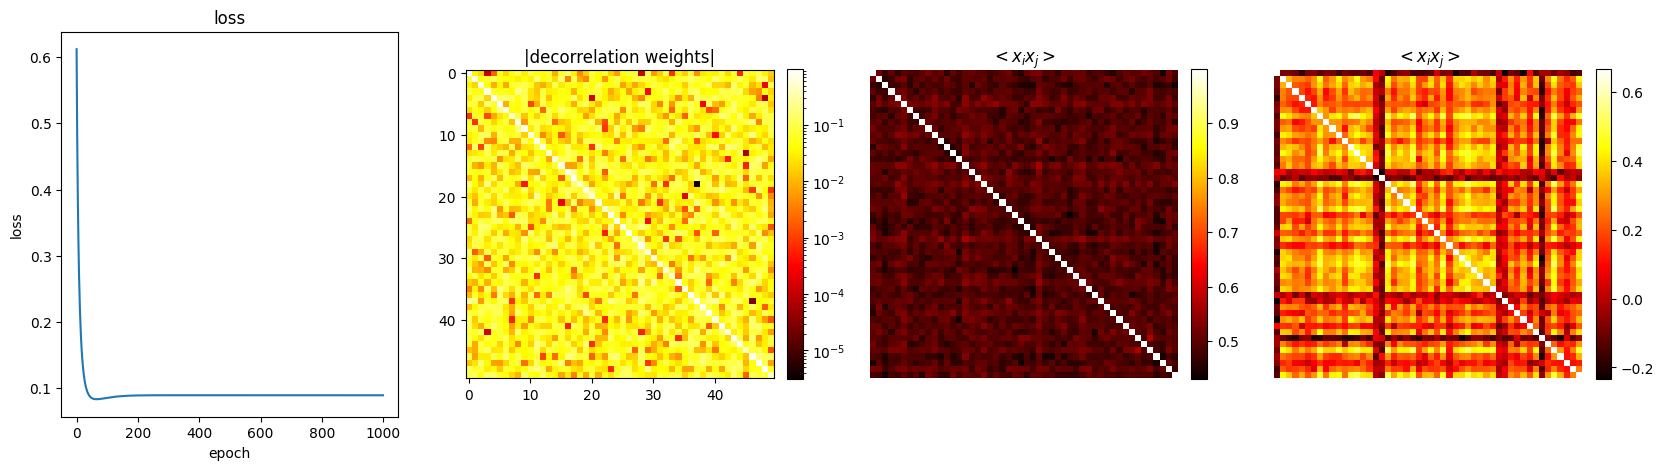

In [117]:
R, loss, data = rule_2_full(d=50, num_samples=1000, num_iters=1000, kappa=0.5, lr=1e-2, seed=40)

fig, ax = plt.subplots(1,4, figsize=(20, 5))
plot_loss(ax[0], loss)
plot_decorrelation_matrix(ax[1], R)
C1 = data.T @ data / len(data)
plot_covariance_matrix(ax[2], C1)
X = data @ R
C2 = X.T @ X / len(X)
plot_covariance_matrix(ax[3], C2)

In [15]:
# sanity checking for rule 2

seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# covariances

C = torch.rand(9,9)
R = torch.rand(9,9)
# R = torch.eye(9)

# we only need the diagonal (c_11,...,c_dd) (values x_j x_j)
c = torch.diag(C)[:, None]

U = torch.zeros(9,9)
for i in range(9):
    for j in range(9):
        if i==j:
            continue
        U[i] += c[j] * R[i]
print(U)

neg_eye = 1.0 - torch.eye(9)

V = neg_eye @ c * R
print(V)


tensor([[0.7190, 3.4577, 1.3460, 3.6302, 1.7230, 3.5514, 0.5038, 1.1190, 2.9478],
        [2.7050, 1.6636, 3.5639, 3.7509, 0.6137, 1.0408, 4.2775, 1.4795, 1.4413],
        [0.0831, 1.0963, 3.2062, 2.2268, 0.7032, 2.6256, 0.8130, 0.3889, 1.1527],
        [0.2776, 0.8081, 4.4480, 2.6446, 2.9099, 0.1497, 0.7635, 1.4840, 2.5723],
        [0.2862, 1.3563, 0.9564, 2.3896, 1.4963, 2.2179, 0.7682, 0.7473, 0.9928],
        [1.7743, 0.5685, 4.9596, 2.1623, 5.0188, 3.5382, 0.4133, 4.5646, 1.9554],
        [1.5013, 0.4137, 0.0142, 3.1310, 1.9027, 3.3823, 0.4366, 4.2419, 0.6474],
        [1.8411, 2.6902, 3.3742, 4.0219, 4.2526, 0.4608, 2.7854, 1.2682, 1.9815],
        [0.6487, 4.9287, 0.6862, 3.9578, 3.4858, 3.4175, 1.1848, 4.9238, 3.1461]])
tensor([[0.7190, 3.4577, 1.3460, 3.6302, 1.7230, 3.5514, 0.5038, 1.1190, 2.9478],
        [2.7050, 1.6636, 3.5639, 3.7509, 0.6137, 1.0408, 4.2775, 1.4795, 1.4413],
        [0.0831, 1.0963, 3.2062, 2.2268, 0.7032, 2.6256, 0.8130, 0.3889, 1.1527],
        [0.2776

In [23]:
R

tensor([[0.4298, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4298, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4298,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4298, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4298, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4298]])